In [10]:
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt

In [13]:
file_path = 'TheSocialDilemma.csv'
data = pd.read_csv(file_path)
# data = data[['text', 'Sentiment']]
# data.head()

In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18252 entries, 0 to 18251
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   user_name         18251 non-null  object
 1   user_location     14465 non-null  object
 2   user_description  16998 non-null  object
 3   user_created      18252 non-null  object
 4   user_followers    18252 non-null  int64 
 5   user_friends      18252 non-null  int64 
 6   user_favourites   18252 non-null  int64 
 7   user_verified     18252 non-null  bool  
 8   date              18252 non-null  object
 9   text              18252 non-null  object
 10  hashtags          14377 non-null  object
 11  source            18252 non-null  object
 12  is_retweet        18252 non-null  bool  
 13  Sentiment         18252 non-null  object
dtypes: bool(2), int64(3), object(9)
memory usage: 1.7+ MB


In [16]:
data = data[['text', 'Sentiment']]
data.head()

def clean_text(text):
  text = text.lower()
  text = re.sub('\[.*?\]', '', text)
  text = re.sub('https?://\S+|www\.\S+', '', text)
  text = re.sub('\n', '', text)
  text = " ".join(filter(lambda x:x[0]!="@", text.split()))
  return text
data['text'] = data['text'].apply(lambda x: clean_text(x))

X = data['text']
y = data['Sentiment'].map({'Negative':0, 'Neutral':1, 'Positive':2})

train_size = int(len(data)*0.8)
X_train, y_train = X[:train_size], y[:train_size]
X_test, y_test = X[train_size:], y[train_size:]
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

print ('Length of text: {} characters'.format(len(X_train)))

print("Max tweet length:", X.map(len).max())
print("Min tweet length:", X.map(len).min())
print("Average tweet length:", X.map(len).mean())

X_train shape: (14601,)
y_train shape: (14601,)
X_test shape: (3651,)
y_test shape: (3651,)
Length of text: 14601 characters
Max tweet length: 144
Min tweet length: 0
Average tweet length: 93.68129520052597


In [3]:
vocab_size = 8000
embedding_dim = 32
max_length = 90
tokenizer = Tokenizer(vocab_size)
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index

train_sequences = tokenizer.texts_to_sequences(X_train)
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding='pre', truncating='pre')
test_sequences = tokenizer.texts_to_sequences(X_test)
test_padded = pad_sequences(test_sequences, maxlen=max_length, padding='pre', truncating='pre')

print("Shape of train_padded:", train_padded.shape)
print("Shape of test_padded:", test_padded.shape)

Shape of train_padded: (14601, 90)
Shape of test_padded: (3651, 90)


In [37]:
# Fungsi Untuk Menghitung jumllah Hidden Node
def count_hidden_nodes(model):
    hidden_nodes = 0

    for layer in model.layers:
        if isinstance(layer, Dense):
            hidden_nodes += layer.units
            print("Jumlah Node Pada ", layer.name, " : ", layer.units)
        elif isinstance(layer, LSTM):
            hidden_nodes += layer.units
            print("Jumlah Node Pada ", layer.name, " : ", layer.units)
        
        # print("Embedding layer has no 'units' attribute")

    return hidden_nodes

In [38]:
# Fungsi untuk menghitung Total Weight
def count_total_weights(model):
    total_weights = 0

    for layer in model.layers:
        if hasattr(layer, 'get_weights'):
            weights = layer.get_weights()
            if weights:
                total_weights += sum(w.size for w in weights)

    return total_weights

In [43]:
# Untuk Melakukan Eksekusi Layer secara berurutan
model = Sequential([
                    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
                    tf.keras.layers.LSTM(100),
                    tf.keras.layers.Dense(max_length/2, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
                    tf.keras.layers.Dropout(0.4),
                    tf.keras.layers.Dense(3, activation='softmax')
])
model.summary()

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    0.01,
    decay_steps=10000,
    decay_rate=0.95,
    staircase=True
)

model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate = lr_schedule),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(train_padded, y_train, epochs=10, validation_data=(test_padded, y_test))

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 90, 32)            256000    
                                                                 
 lstm_2 (LSTM)               (None, 100)               53200     
                                                                 
 dense_4 (Dense)             (None, 45)                4545      
                                                                 
 dropout_2 (Dropout)         (None, 45)                0         
                                                                 
 dense_5 (Dense)             (None, 3)                 138       
                                                                 
Total params: 313883 (1.20 MB)
Trainable params: 313883 (1.20 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/10
457/457

In [44]:
# Count hidden nodes
hidden_nodes_count = count_hidden_nodes(model)
print(f'Total Hidden Nodes : {hidden_nodes_count}')

Jumlah Node Pada  lstm_2  :  100
Jumlah Node Pada  dense_4  :  45
Jumlah Node Pada  dense_5  :  3
Total Hidden Nodes : 148


In [45]:
# Count total weights
total_weights_count = count_total_weights(model)
print(f'Total Trainable Weights : {total_weights_count}')


Total Trainable Weights : 313883


In [46]:
# Model Saved
model.save('tweet_dilema.h5')

/home/meone/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [47]:
from tensorflow.keras.models import load_model

# Load the model
loaded_model = load_model('tweet_dilema.h5')


In [48]:
loss, accuracy = model.evaluate(train_padded, y_train, verbose = 0)
print('Accuracy: %f' % (accuracy*100))

Accuracy: 99.376756


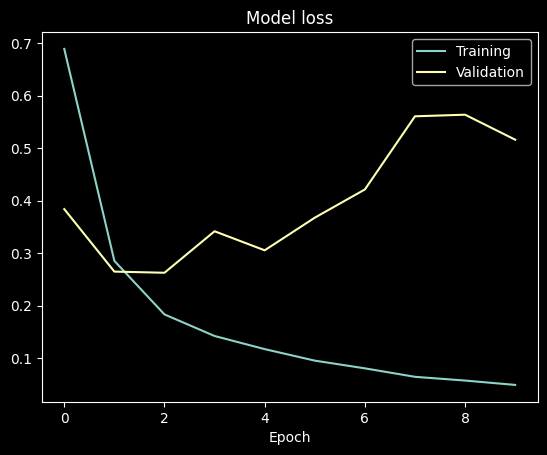

In [49]:
# Loss graph
plt.style.use('dark_background')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('Model loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc = 'upper right')
plt.show()

In [50]:
from keras.callbacks import TensorBoard
import datetime
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)
history = model.fit(train_padded, y_train, epochs=10, validation_data=(test_padded, y_test), callbacks=[tensorboard_callback])

Epoch 1/10
457/457 [==============================] - 18s 39ms/step - loss: 0.0446 - accuracy: 0.9913 - val_loss: 0.6101 - val_accuracy: 0.9236
Epoch 2/10
457/457 [==============================] - 17s 38ms/step - loss: 0.0408 - accuracy: 0.9921 - val_loss: 0.6004 - val_accuracy: 0.9093
Epoch 3/10
457/457 [==============================] - 18s 38ms/step - loss: 0.0315 - accuracy: 0.9933 - val_loss: 0.7386 - val_accuracy: 0.9263
Epoch 4/10
457/457 [==============================] - 18s 39ms/step - loss: 0.0326 - accuracy: 0.9947 - val_loss: 0.6514 - val_accuracy: 0.9167
Epoch 5/10
457/457 [==============================] - 18s 39ms/step - loss: 0.0295 - accuracy: 0.9943 - val_loss: 0.7264 - val_accuracy: 0.9247
Epoch 6/10
457/457 [==============================] - 18s 39ms/step - loss: 0.0265 - accuracy: 0.9950 - val_loss: 0.7950 - val_accuracy: 0.9099
Epoch 7/10
457/457 [==============================] - 18s 39ms/step - loss: 0.0195 - accuracy: 0.9965 - val_loss: 0.8048 - val_accuracy:

In [51]:
%load_ext tensorboard

In [52]:
%tensorboard --logdir logs/fit

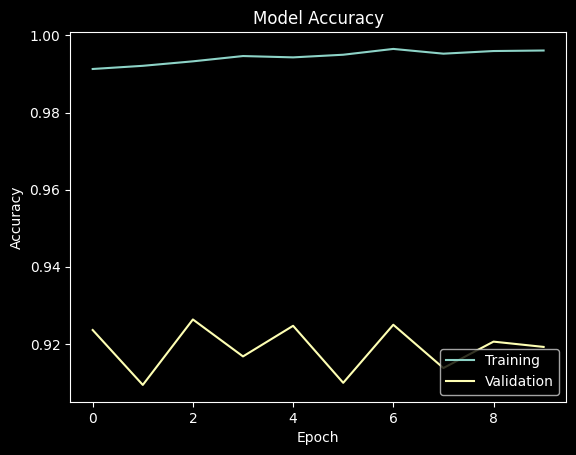

In [53]:
plt.style.use('dark_background')
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc = 'lower right')
plt.show()

In [54]:
def get_encode(x):
  #x = clean_text(x)
  x = tokenizer.texts_to_sequences(x)
  x = tf.keras.preprocessing.sequence.pad_sequences(x, maxlen=max_length, padding='pre', truncating='pre')
  return x

test_comment = ['This movie depicted the current society issues so well, I loved it so much']

seq = tokenizer.texts_to_sequences(test_comment)
padded = pad_sequences(seq, maxlen=max_length, padding='pre', truncating='pre')
print(padded.shape)
y_pred = model.predict(padded).round()
print(y_pred)

(1, 90)
1/1 [==============================] - 0s 369ms/step
[[0. 0. 1.]]
